# A 2D Infinite Fuel Pin Geometry of the SNRE 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import openmc

openmc.Materials.cross_sections = "/home/jimmy/Documents/SNRE_UROP/SNRE/SNRE_OpenMC/SNRE_2DFuelPinModelling/dataLibrary/cross_sections.xml"

# Materials definitions
fuel = openmc.Material(name='fuel', temperature=300)
fuel.set_density('g/cm3', 3.64)
fuel.add_nuclide('U235', 0.558, 'wo')
fuel.add_nuclide('U238', 0.042, 'wo')
fuel.add_nuclide('Zr0', 1.81, 'wo')
fuel.add_nuclide('C0', 1.23, 'wo')
fuel.add_s_alpha_beta('c_Graphite')

coolant = openmc.Material(name='coolant', temperature=300)
coolant.set_density('atom/b-cm', 1.61317e-3)
coolant.add_nuclide('H1', 1.0, 'wo')
coolant.add_s_alpha_beta('c_para_H')

cladding = openmc.Material(name='cladding', temperature=300)
cladding.set_density('g/cm3', 6.73)
cladding.add_nuclide('Zr0', 0.88375, 'wo')
cladding.add_nuclide('C0', 0.11625, 'wo')
cladding.add_s_alpha_beta('c_Graphite')

# Materials xml
materials = openmc.Materials([fuel, coolant, cladding])
materials.export_to_xml('./xmlFiles/')

# Geometry definitions
channelRadius = 0.11827
cladOuterRadius = 0.12827
pinPitch = 0.40894
subassemblyDuctOuter = 1.905
subassemblyDuctThickness = 0.005
subassemblyDuctInner = subassemblyDuctOuter - 2*subassemblyDuctThickness

# Boudaries and outer universe
fuelOut = openmc.Cell(cell_id=200, fill=fuel)

# Inner Hexagon
assemblyHex = openmc.hexagonal_prism(edge_length=subassemblyDuctInner / np.sqrt(3.),
                                        orientation='x')

# Outer Hexagon
cladOuterHex = openmc.hexagonal_prism(edge_length=subassemblyDuctOuter / np.sqrt(3.), 
                                         orientation='x',
                                         boundary_type='reflective')

assemblyCell = openmc.Cell()
cladOuterCell = openmc.Cell()
voidCell = openmc.Cell()

assemblyCell.region = assemblyHex
cladOuterCell.region = ~assemblyHex & cladOuterHex 
voidCell.region = ~cladOuterHex
cladOuterCell.fill = cladding

# Create universes
fuelOutUni = openmc.Universe(cells=(fuelOut,))
cladOuterUni = openmc.Universe(cells=[cladOuterCell])
rootUni = openmc.Universe()

coolantChannelOuter = openmc.ZCylinder(surface_id=400, r=channelRadius)
cladChannelOuter = openmc.ZCylinder(surface_id=402, r=cladOuterRadius)

coolantChannelCell  = openmc.Cell(cell_id=400, fill=coolant, region=-coolantChannelOuter)
cladChannelCell  = openmc.Cell(cell_id=401, fill=cladding, region=+coolantChannelOuter & -cladChannelOuter)
fuelChannelCell = openmc.Cell(cell_id=402, fill=fuel, region=+cladChannelOuter)

channelUni = openmc.Universe(cells=[fuelChannelCell, cladChannelCell, coolantChannelCell])

# Creating the hexagonal lattice
lattice=openmc.HexLattice(name='assembly')
lattice.center = (0., 0.)
lattice.pitch = (pinPitch,)
lattice.outer = fuelOutUni
ring2=[channelUni]*12
ring1=[channelUni]*6
ring0=[channelUni]
lattice.universes = [ring2, ring1, ring0]
lattice.orientation='x'
assemblyCell.fill = lattice

rootUni.add_cells([assemblyCell, cladOuterCell, voidCell])
geom=openmc.Geometry(rootUni)
geom.export_to_xml('./xmlFiles/')

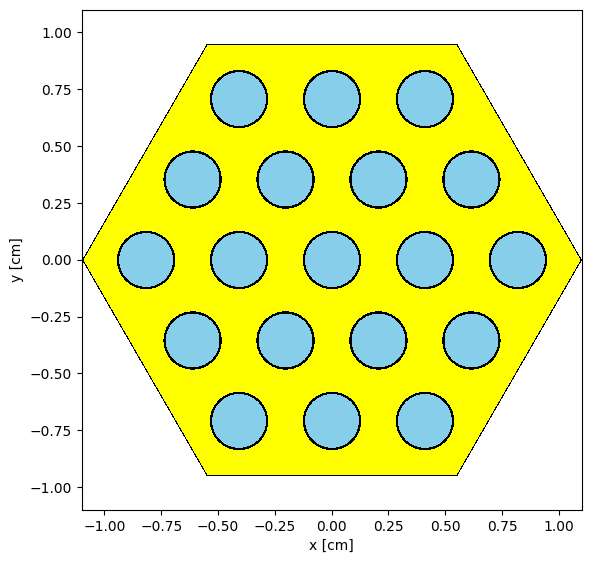

In [2]:
rootUni.plot(origin=(0,0,0),width=(2.2,2.2),color_by='material',colors={fuel: 'yellow', coolant: 'skyblue', cladding: 'black',},pixels=[500,500])

In [3]:
# OpenMC simulation parameters

settings = openmc.Settings()
settings.run_mode = 'eigenvalue'

settings.particles = 100000
settings.generations_per_batch = 20
settings.batches = 100
settings.inactive = 20
settings.export_to_xml('./xmlFiles/')

source = openmc.IndependentSource()
source.space = openmc.stats.Point(xyz=(0.0, 0.0, 0.0))

mesh = openmc.RegularMesh()
mesh.dimension = [500, 500]
mesh.lower_left = [-1.1, -1.1]
mesh.upper_right = [1.1, 1.1]

tallies = openmc.Tallies()

fuelAllTally = openmc.Tally(tally_id=1)
fuelAllTally.filters = [openmc.MeshFilter(mesh)]
fuelAllTally.scores = ['flux', 'fission']
tallies.append(fuelAllTally)

fuelThermalTally = openmc.Tally(tally_id=2)
fuelThermalTally.filters = [openmc.MeshFilter(mesh), openmc.EnergyFilter([0,0.1])]
fuelThermalTally.scores = ['flux', 'fission']
tallies.append(fuelThermalTally)

fuelFastTally = openmc.Tally(tally_id=3)
fuelFastTally.filters = [openmc.MeshFilter(mesh), openmc.EnergyFilter([0.1,1e6])]
fuelFastTally.scores = ['flux', 'fission']
tallies.append(fuelFastTally)

tallies.export_to_xml('./xmlFiles/')

openmc.run(path_input='./xmlFiles/')

/home/jimmy/.local/lib/python3.10/site-packages/openmc/mixin.py:70: IDWarning: Another Filter instance already exists with id=1.
  warn(msg, IDWarning)


                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

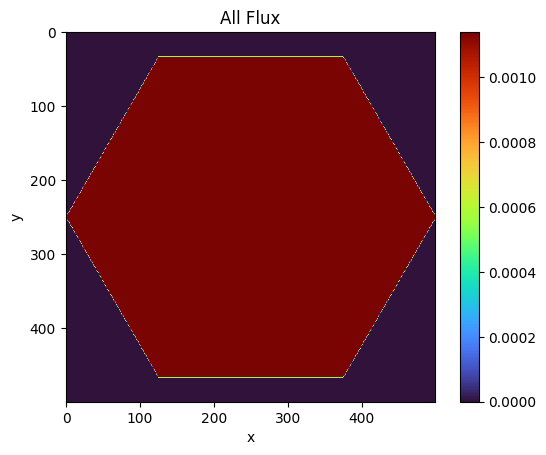

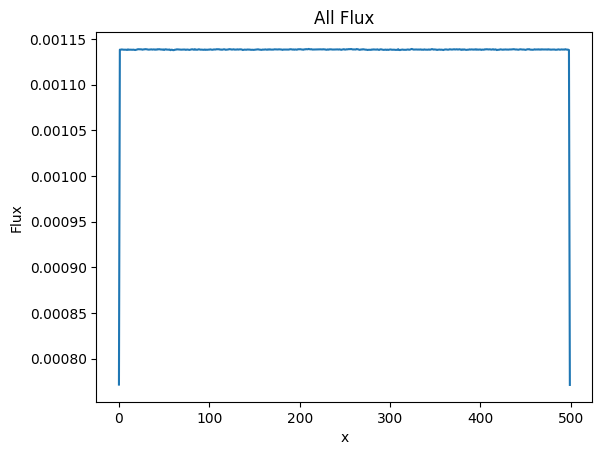

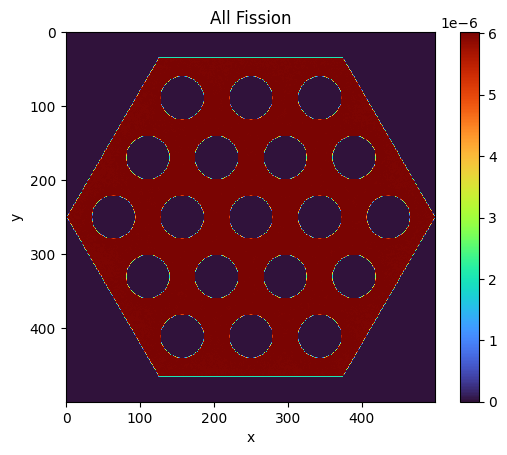

In [7]:
with openmc.StatePoint('statepoint.{}.h5'.format(settings.batches)) as sp:
    outputAllTally = sp.get_tally(id=1)
    dfAll = outputAllTally.get_pandas_dataframe()
    dfAllFlux = dfAll[dfAll['score'] == 'flux']
    dfAllFission = dfAll[dfAll['score'] == 'fission']
    
# print(outputAllTally)
# print(dfAll)
# print(dfAllFlux)
# print(dfAllFission)
# print(dfAllFlux['mean'])

meanAllFlux = dfAllFlux['mean'].values.reshape((500,500))
plt.imshow(meanAllFlux, interpolation='nearest', cmap='turbo')
plt.title('All Flux')
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()
plt.savefig('./pics/AllFlux.png', dpi=300)
#plt.clim(0.0008,0.0012)
plt.show()

meanAllFluxAx = np.column_stack((np.arange(500), meanAllFlux[250]))
np.savetxt('./dataFiles/meanAllFluxAx.csv', meanAllFluxAx, delimiter=',', fmt='%s')
meanAllFluxAxData, meanAllFluxAxPos = meanAllFluxAx[:,0], meanAllFluxAx[:,1]
plt.plot(meanAllFluxAxData,meanAllFluxAxPos)
plt.title('All Flux')
plt.xlabel('x')
#plt.ylim(bottom=0.0008)
plt.ylabel('Flux')
plt.savefig('./pics/AllFluxAx.png', dpi=300)
plt.show()

meanAllFission = dfAllFission['mean'].values.reshape((500,500))
plt.imshow(meanAllFission, interpolation='nearest', cmap='turbo')
plt.title('All Fission')
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()
#plt.clim(6e-6,8e-6)
plt.savefig('./pics/AllFission.png', dpi=300)
plt.show()

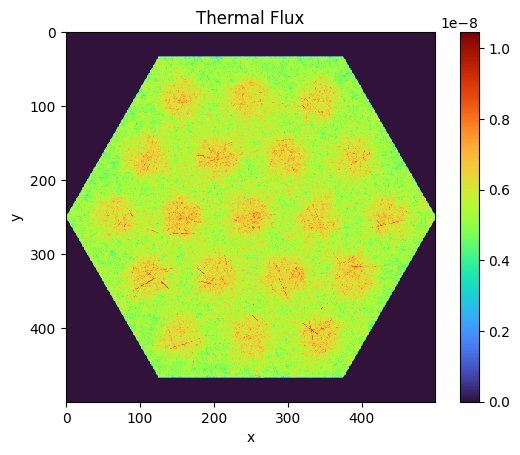

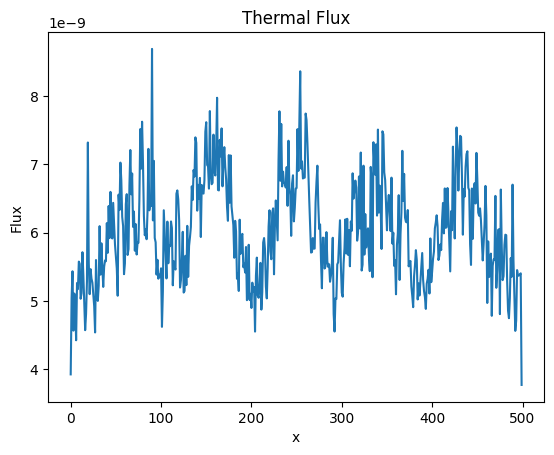

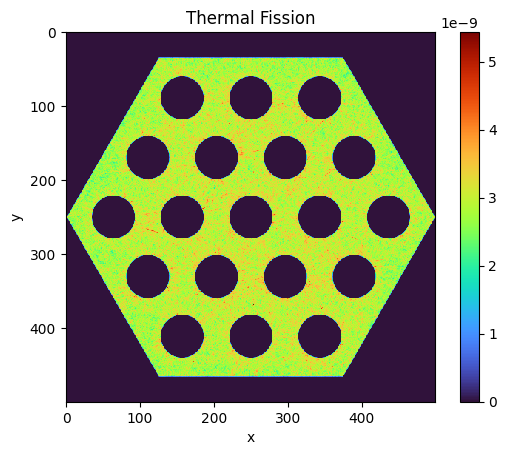

In [8]:
with openmc.StatePoint('statepoint.{}.h5'.format(settings.batches)) as sp:
    outputThermalTally = sp.get_tally(id=2)
    dfThermal = outputThermalTally.get_pandas_dataframe()
    dfThermalFlux = dfThermal[dfThermal['score'] == 'flux']
    dfThermalFission = dfThermal[dfThermal['score'] == 'fission']

# print(outputThermalTally)
# print(dfThermal)
# print(dfThermalFlux)
# print(dfThermalFission)
# print(dfThermalFlux['mean'])

meanThermalFlux = dfThermalFlux['mean'].values.reshape((500,500))
plt.imshow(meanThermalFlux, interpolation='nearest', cmap='turbo')
plt.title('Thermal Flux')
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()
plt.savefig('./pics/ThermalFlux.png', dpi=300)
#plt.clim(0.0008,0.0012)
plt.show()

meanThermalFluxAx = np.column_stack((np.arange(500), meanThermalFlux[250]))
np.savetxt('./dataFiles/meanThermalFluxAx.csv', meanThermalFluxAx, delimiter=',', fmt='%s')
meanThermalFluxAxData, meanThermalFluxAxPos = meanThermalFluxAx[:,0], meanThermalFluxAx[:,1]
plt.plot(meanThermalFluxAxData,meanThermalFluxAxPos)
plt.title('Thermal Flux')
plt.xlabel('x')
#plt.ylim(bottom=0.0008)
plt.ylabel('Flux')
plt.savefig('./pics/ThermalFluxAx.png', dpi=300)
plt.show()

meanThermalFission = dfThermalFission['mean'].values.reshape((500,500))
plt.imshow(meanThermalFission, interpolation='nearest', cmap='turbo')
plt.title('Thermal Fission')
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()
#plt.clim(6e-6,8e-6)
plt.savefig('./pics/ThermalFission.png', dpi=300)
plt.show()

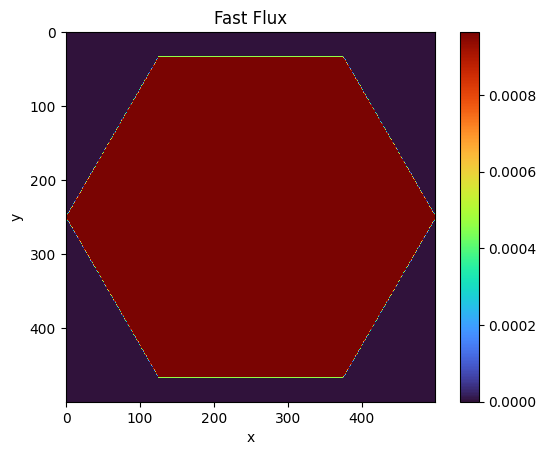

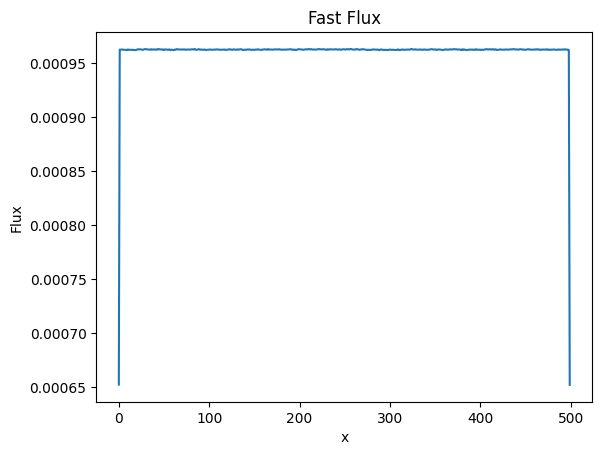

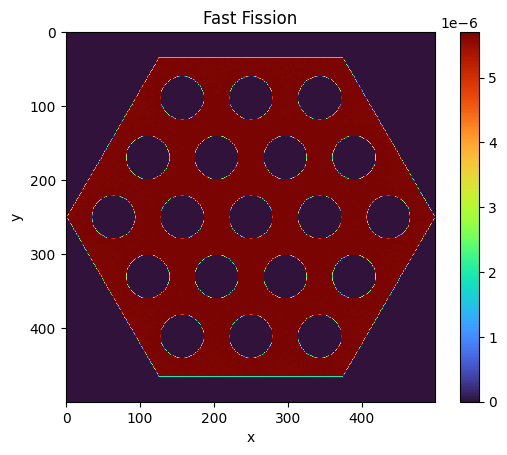

In [9]:
with openmc.StatePoint('statepoint.{}.h5'.format(settings.batches)) as sp:
    outputFastTally = sp.get_tally(id=3)
    dfFast = outputFastTally.get_pandas_dataframe()
    dfFastFlux = dfFast[dfFast['score'] == 'flux']
    dfFastFission = dfFast[dfFast['score'] == 'fission']

# print(outputFastTally)
# print(dfFast)
# print(dfFastFlux)
# print(dfFastFission)
# print(dfFastFlux['mean'])

meanFastFlux = dfFastFlux['mean'].values.reshape((500,500))
plt.imshow(meanFastFlux, interpolation='nearest', cmap='turbo')
plt.title('Fast Flux')
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()
#plt.clim(0.0008,0.0012)
plt.savefig('./pics/FastFlux.png', dpi=300)
plt.show()

meanFastFluxAx = np.column_stack((np.arange(500), meanFastFlux[250]))
np.savetxt('./dataFiles/meanFastFluxAx.csv', meanFastFluxAx, delimiter=',', fmt='%s')
meanFastFluxAxData, meanFastFluxAxPos = meanFastFluxAx[:,0], meanFastFluxAx[:,1]
plt.plot(meanFastFluxAxData,meanFastFluxAxPos)
plt.title('Fast Flux')
plt.xlabel('x')
#plt.ylim(bottom=0.0008)
plt.ylabel('Flux')
plt.savefig('./pics/FastFluxAx.png', dpi=300)
plt.show()

meanFastFission = dfFastFission['mean'].values.reshape((500,500))
plt.imshow(meanFastFission, interpolation='nearest', cmap='turbo')
plt.title('Fast Fission')
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()
#plt.clim(6e-6,8e-6)
plt.savefig('./pics/FastFission.png', dpi=300)
plt.show()